# Time Series Forecast: ARIMA and ARIMAX


ARIMAX models extend [ARIMA](https://github.com/HsiangHung/MachineLearningNote/blob/master/Time%20series/time%20series%20-%20ARIMA%20.ipynb) (Autoregressive integrated moving average) models through the inclusion of exogenous variables X. We write an ARIMAX(p,d,q) model for some time series data $y_t$ and exogenous varibale (feature) $X_t$, where $p$ is the number of autoregressive lags, $d$ is the degree of differencing of $y_t \to y^*_t = \Delta^d y_t$ and $q$ is the number of moving average lags as:

$$ y^*_t = \sum^p_{i=1} \phi_i y^*_{t-i} + \sum^q_{j=1} \theta_j \epsilon_{t-j} + \sum^M_{f=1} \beta_{f,t} X_{f,t} + \epsilon_t$$ 

Here we have $M$ exogenous features, and $\epsilon_t \in N(0, \sigma^2)$ is white noise. As all $\beta_{f,t}=0$, the model returns to ARIMA(p,d,q). For the detail, read the [implementation of ARIMA model](https://github.com/HsiangHung/MachineLearningNote/blob/master/Time%20series/time%20series%20-%20ARIMA%20.ipynb).

The [Pyflux](https://pyflux.readthedocs.io/en/latest/arimax.html) package supports the ARIMAX model implementation using Python. The ARIMAX model has been implemented in industry, such as [Xi-Cheng](http://www.10tiao.com/html/183/201809/2697267472/1.html), to preidct volumne of customer service calls, and [financial firm](https://www.joinquant.com/post/10607).

In [1]:
import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

#data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv")
data = pd.read_csv("drivers.csv")
data.index = data['time'];

print (data.shape)

data.head()

(192, 3)


,Unnamed: 0,time,value
time,,,
1969.000000,1,1969.000000,1687
1969.083333,2,1969.083333,1508
1969.166667,3,1969.166667,1507
1969.250000,4,1969.250000,1385
1969.333333,5,1969.333333,1632


**value** in data is the number of monthly UK driver death from 1969 to 1984, totally 192 months. **values** vs **time** forms time-series data. The data source is from [here]( https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv). In case not able to connect it, here we also attach as **drivers.csv**.

There are two interventions we are interested in: the 1974 **oil_crisis** and the introduction of the **seat_belt** law in 1983. The oil crisis starts in 1974 (so turn False to True in 1974) and the seatbelt law launches in 1983 (so turn False to True in 1983). Therefore the exogenous variables are $X_{\textrm{oil_crisis}}$ and $X_{\textrm{seat_belt}}$. 

We will model the effects of these events as structural breaks, such that 

$$ \textrm{If t} \le 1974, \ X_{\textrm{oil_crisis}} = 1; \textrm{otherwise} \ X_{\textrm{oil_crisis}} = 0.$$

$$ \textrm{If t} \le 1983, \ X_{\textrm{seat_belt}} = 1; \textrm{otherwise} \ X_{\textrm{seat_belt}} = 0.$$

In [2]:
data.loc[(data['time']>=1983.05), 'seat_belt'] = 1;
data.loc[(data['time']<1983.05), 'seat_belt'] = 0;
data.loc[(data['time']>=1974.00), 'oil_crisis'] = 1;
data.loc[(data['time']<1974.00), 'oil_crisis'] = 0;
data.head()

,Unnamed: 0,time,value,seat_belt,oil_crisis
time,,,,,
1969.000000,1,1969.000000,1687,0.0,0.0
1969.083333,2,1969.083333,1508,0.0,0.0
1969.166667,3,1969.166667,1507,0.0,0.0
1969.250000,4,1969.250000,1385,0.0,0.0
1969.333333,5,1969.333333,1632,0.0,0.0


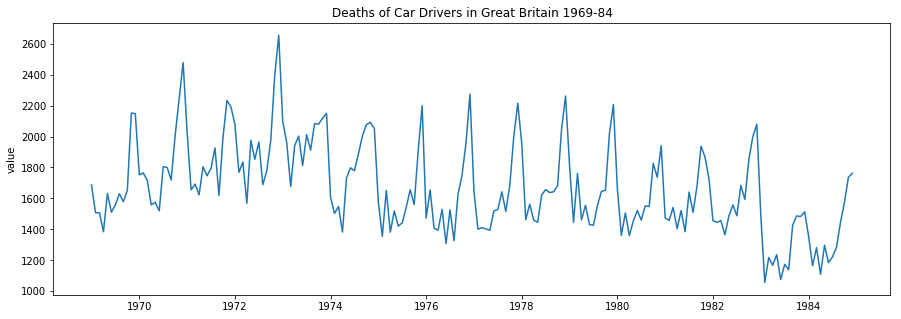

In [3]:
plt.figure(figsize=(15,5));
plt.plot(data.index,data['value']);
plt.ylabel('value');
plt.title('Deaths of Car Drivers in Great Britain 1969-84');
plt.plot();

## Autocorrelation

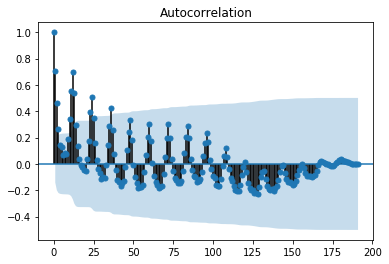

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['value'].tolist())
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


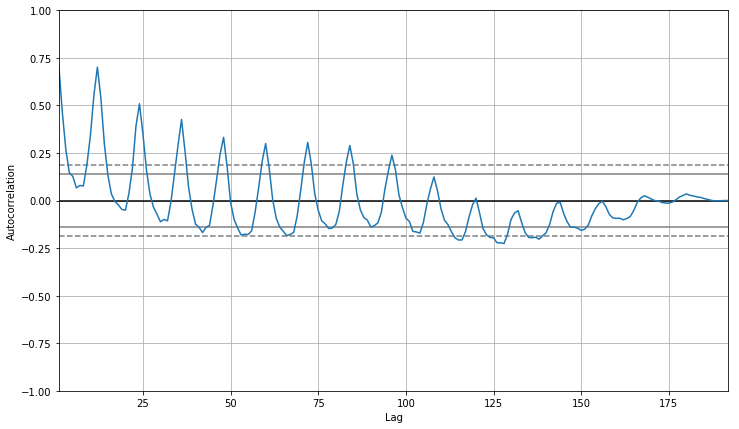

In [6]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(12,7))
autocorrelation_plot(data['value'])
plt.show()

From the autocorrelation plot, we can observe the correlation strength drops below $2\sigma$ threshold after lag < 12-13. Therefore we can roughly guess $p = 12$ if using ARIMA(p,d,q).

## Partial Autocorrelation

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


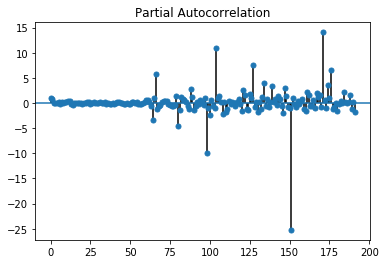

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['value'].tolist())
plt.show()

## ARIMA Model

To model a time series data, we separate training and test datasets. We assigne the first 66% data as training dataset, and the remaining as test dataset. At each time step $t$, we train the model to forecast next step $t+1$, and then evaluate the prediction error $\epsilon = \widehat{y}(t+1)-y(t+1)$. After that, update training set by the current event for next time step model. 

Assume we have separate data as training/test datasets denoting as {D(0), D(1), ...D(h)} and {D(h+1), ... D(M)}. D(t) = {X(t), y(t)} denotes the data at time = t. In the ARIMA model, we only describe the relation D(t) = y(t). 

First step:

    model = ARIMA(training_data = {y(0), y(1),.... y(h)}, order=(p,d,q))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]  (only consider one time step ahead prediction)
    error += (y^(h+1)-y(h+1))**2
    training_data = {y(0), ... y(h), y(h+1)}
    
Second step:

    model = ARIMA(training_data = {y(0),.... y(h), y(h+1)}, order=(p,d,q))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]  (only consider one time step ahead prediction)
    error += (y^(h+2)- y(h+2))**2
    training_data = {y(0), ... y(h+1), y(h+2)}


The rolling forecast scenario is called walk-forward model validation.

In [132]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data['value'].tolist(), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  191
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1294.085
Method:                       css-mle   S.D. of innovations            211.805
Date:                Tue, 13 Nov 2018   AIC                           2602.169
Time:                        15:47:53   BIC                           2624.935
Sample:                             1   HQIC                          2611.390
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1592      9.434      0.017      0.987     -18.330      18.649
ar.L1.D.y     -0.1280      0.072     -1.768      0.079      -0.270       0.014
ar.L2.D.y     -0.1274      0.071     -1.786      0.0

In the following, we just randomly run an ARIMA model(10,1,0), and visualize the difference.

In [9]:
from sklearn.metrics import mean_squared_error

X = data['value'].tolist()
size = int(len(X) * 0.66)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 27636.474


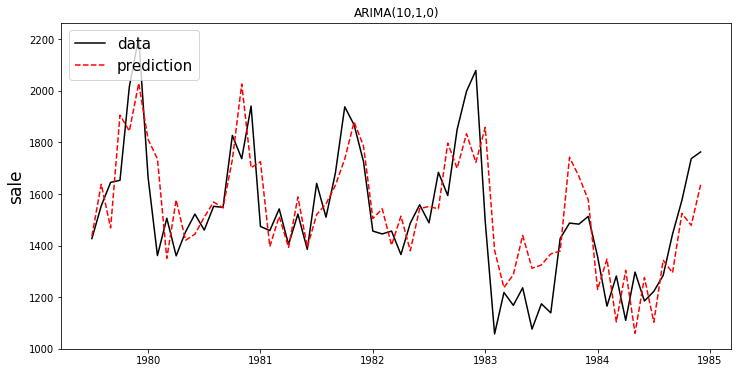

In [10]:
plt.figure(figsize=(12,6))
plt.plot(data['time'].tolist()[size:], test, color='k', label='data')
plt.plot(data['time'].tolist()[size:], predictions, '--', color='red', label ='prediction')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(10,1,0)')
plt.ylabel('sale', fontsize=17)
plt.show()

### Grid Search on (p,d,q)

Strictly speaking, we need to do grid search on values of p,d,q, to find optimal performace. The following shows the grid search results, $0 \le p \le 15$, $0 \le d \le 3$ and $0 \le q \le 4$:

In [ ]:
def evaluate_ARIMA_mse(train, test, parameters):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=parameters)
        model_fit = model.fit(disp=0, verbose=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)/len(test)
    return round(error, 3), round(model_fit.aic, 3)


min_mse, min_aic, best_pdq = float('inf'), float('inf'), None
for p in range(15):
    for d in range(3):
        for q in range(4):
            try:
                X = data['value'].tolist()
                size = int(len(X) * 0.66)
                train, test = X[0:size], X[size:len(X)]
                mse, aic = evaluate_ARIMA_mse(train, test, (p,d,q))
                print ((p, d, q), 'MSE: ', mse, 'AIC: ', aic)
                if mse < min_mse:
                    min_mse, min_aic, best_pdq = mse, aic, (p,d,q)
            except:
                pass
            
print (best_pdq, min_mse, min_aic)

(0, 0, 1) MSE:  792.865 AIC:  2617.634
(0, 0, 2) MSE:  632.531 AIC:  2593.715
(0, 0, 3) MSE:  565.424 AIC:  2580.996
(0, 1, 1) MSE:  570.024 AIC:  2595.618
(0, 1, 2) MSE:  566.169 AIC:  2581.335
(0, 1, 3) MSE:  502.931 AIC:  2568.603
(0, 2, 1) MSE:  570.827 AIC:  2589.663
(1, 0, 0) MSE:  535.82 AIC:  2580.418
(1, 0, 1) MSE:  541.067 AIC:  2581.41
(1, 0, 2) MSE:  543.609 AIC:  2582.275
(1, 0, 3) MSE:  579.691 AIC:  2580.452
(1, 1, 0) MSE:  565.805 AIC:  2595.917
(1, 1, 1) MSE:  487.228 AIC:  2565.097


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 2) MSE:  481.057 AIC:  2564.862
(1, 1, 3) MSE:  473.442 AIC:  2564.565
(1, 2, 0) MSE:  869.541 AIC:  2675.773
(2, 0, 0) MSE:  543.384 AIC:  2581.226
(2, 0, 1) MSE:  550.759 AIC:  2582.841
(2, 0, 2) MSE:  553.601 AIC:  2584.19


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


(2, 1, 0) MSE:  568.937 AIC:  2596.305
(2, 1, 1) MSE:  477.654 AIC:  2564.034


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 1, 2) MSE:  479.531 AIC:  2551.649


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 2, 0) MSE:  819.7 AIC:  2659.195
(3, 0, 0) MSE:  549.249 AIC:  2582.486
(3, 0, 1) MSE:  552.674 AIC:  2584.486


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 0) MSE:  560.915 AIC:  2594.323
(3, 1, 1) MSE:  474.217 AIC:  2563.211
(3, 1, 2) MSE:  471.696 AIC:  2551.537


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

(3, 2, 0) MSE:  774.446 AIC:  2653.338
(4, 0, 0) MSE:  555.888 AIC:  2584.485
(4, 0, 1) MSE:  553.273 AIC:  2578.945


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 0, 2) MSE:  553.196 AIC:  2578.144


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

(4, 1, 0) MSE:  559.457 AIC:  2587.381
(4, 1, 1) MSE:  465.181 AIC:  2564.326
(4, 1, 2) MSE:  486.657 AIC:  2560.309


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

(4, 1, 3) MSE:  447.02 AIC:  2549.784
(4, 2, 0) MSE:  746.552 AIC:  2631.44
(4, 2, 1) MSE:  572.766 AIC:  2583.024
(5, 0, 0) MSE:  549.777 AIC:  2584.445


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(5, 0, 2) MSE:  504.368 AIC:  2574.871


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(5, 1, 0) MSE:  563.393 AIC:  2589.379
(5, 1, 1) MSE:  479.557 AIC:  2566.262
(5, 1, 2) MSE:  493.033 AIC:  2561.512


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

(5, 1, 3) MSE:  491.546 AIC:  2551.722
(5, 2, 0) MSE:  740.924 AIC:  2631.097


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 2, 1) MSE:  577.411 AIC:  2585.023
(6, 0, 0) MSE:  570.23 AIC:  2584.565
(6, 0, 1) MSE:  568.838 AIC:  2582.03


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:483: RuntimeWarning: overflow encountered in true_divide
  Hinv = eigvecs.dot(np.diag(1.0 / eigvals)).dot(eigvecs.T)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels

(6, 0, 2) MSE:  599.668 AIC:  2576.87
(6, 1, 0) MSE:  550.523 AIC:  2584.113
(6, 1, 1) MSE:  472.252 AIC:  2556.181


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(6, 2, 0) MSE:  725.578 AIC:  2623.336
(6, 2, 1) MSE:  563.616 AIC:  2580.111


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(6, 2, 2) MSE:  578.228 AIC:  2581.776
(7, 0, 0) MSE:  561.197 AIC:  2584.541
(7, 0, 1) MSE:  492.388 AIC:  2570.504


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


(7, 1, 0) MSE:  548.278 AIC:  2585.127
(7, 1, 1) MSE:  465.816 AIC:  2555.549


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1833: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(7, 2, 0) MSE:  728.94 AIC:  2625.332
(7, 2, 1) MSE:  561.604 AIC:  2581.242


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(7, 2, 2) MSE:  562.913 AIC:  2582.541
(8, 0, 0) MSE:  568.853 AIC:  2586.532
(8, 0, 1) MSE:  484.676 AIC:  2569.917


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

(8, 1, 0) MSE:  489.435 AIC:  2568.188
(8, 1, 1) MSE:  429.959 AIC:  2537.271
(8, 1, 2) MSE:  366.627 AIC:  2509.312
(8, 2, 0) MSE:  711.881 AIC:  2623.19


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(8, 2, 1) MSE:  501.75 AIC:  2564.752


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site

(8, 2, 2) MSE:  438.012 AIC:  2533.344
(9, 0, 0) MSE:  511.066 AIC:  2575.86
(9, 0, 1) MSE:  444.826 AIC:  2551.681


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(9, 1, 0) MSE:  466.289 AIC:  2558.533
(9, 1, 1) MSE:  427.087 AIC:  2532.674
(9, 1, 2) MSE:  391.487 AIC:  2507.265
(9, 1, 3) MSE:  363.535 AIC:  2497.412
(9, 2, 0) MSE:  710.594 AIC:  2624.801


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(9, 2, 2) MSE:  461.942 AIC:  2528.721
(10, 0, 0) MSE:  483.611 AIC:  2569.273
(10, 0, 1) MSE:  440.619 AIC:  2547.198
(10, 0, 2) MSE:  404.642 AIC:  2520.569
(10, 1, 0) MSE:  418.734 AIC:  2516.624
(10, 1, 1) MSE:  400.834 AIC:  2507.794


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(10, 1, 2) MSE:  346.454 AIC:  2483.683


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(10, 1, 3) MSE:  406.035 AIC:  2490.73
(10, 2, 0) MSE:  693.917 AIC:  2609.365


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(10, 2, 1) MSE:  423.428 AIC:  2513.199


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(10, 2, 2) MSE:  413.59 AIC:  2501.027
(11, 0, 0) MSE:  431.061 AIC:  2530.545


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(11, 1, 0) MSE:  366.741 AIC:  2493.575


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(11, 1, 1) MSE:  356.874 AIC:  2492.858
(11, 1, 2) MSE:  351.309 AIC:  2482.102
(11, 1, 3) MSE:  369.966 AIC:  2484.027


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(11, 2, 0) MSE:  418.45 AIC:  2530.103


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(11, 2, 1) MSE:  354.633 AIC:  2481.2


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(11, 2, 2) MSE:  356.516 AIC:  2483.111
(12, 0, 0) MSE:  380.295 AIC:  2508.885
(12, 1, 0) MSE:  342.634 AIC:  2488.498
(12, 1, 1) MSE:  326.477 AIC:  2481.252
(12, 1, 2) MSE:  364.361 AIC:  2480.737


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(12, 1, 3) MSE:  360.081 AIC:  2481.988


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(12, 2, 0) MSE:  370.312 AIC:  2489.002


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

(12, 2, 1) MSE:  359.52 AIC:  2482.878


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(12, 2, 2) MSE:  352.946 AIC:  2481.831


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

(12, 2, 3) MSE:  380.149 AIC:  2478.928
(13, 0, 0) MSE:  353.451 AIC:  2503.06


We find the optimal model is giveb by 

In [14]:
print (best_pdq, min_mse, min_aic)

(12, 1, 1) 326.477 2481.252


In [130]:
best_pdq = (12,1,1)

(12, 1, 1) , Test MSE: 326.476


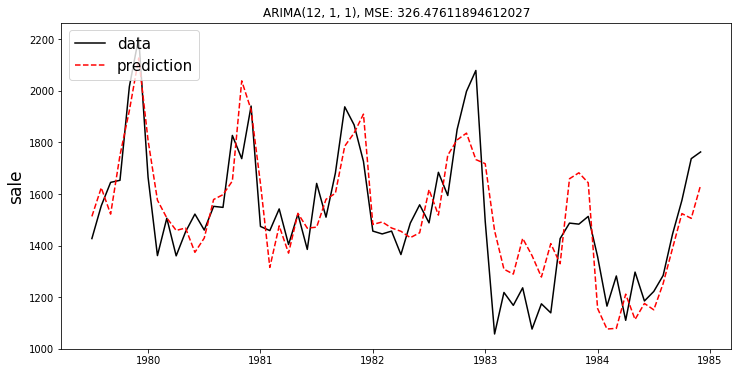

In [133]:
X = data['value'].tolist()
size = int(len(X) * 0.66)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=best_pdq)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)/len(test)
print(best_pdq, ', Test MSE: %.3f' % error)

plt.figure(figsize=(12,6))
plt.plot(data['time'].tolist()[size:], test, color='k', label='data')
plt.plot(data['time'].tolist()[size:], predictions, '--', color='red', label ='prediction')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA'+str(best_pdq)+', MSE: '+str(error))
plt.ylabel('sale', fontsize=17)
plt.show()

From the comparison between data and predictions, we see our model has captured some patterns.

## ARIMAX Model

ARIMA model does not consider exogenous variables X. Next we try using the [ARIMAX model](https://pyflux.readthedocs.io/en/latest/arimax.html), i.e. ARIMA + $X_{\textrm{oil_crisis}}$ and $X_{\textrm{seat_belt}}$.

First, let's tentstively run the model using all data with $p = q=1 $ and $d=0$: 

In [59]:
data.columns

Index(['Unnamed: 0', 'time', 'value', 'seat_belt', 'oil_crisis'], dtype='object')

In [4]:
model = pf.ARIMAX(data=data, formula='value~1+seat_belt+oil_crisis',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: value                               Method: MLE                                       
Start Date: 1969.08333333333                            Log Likelihood: -1278.7644                        
End Date: 1984.91666666667                              AIC: 2569.5288                                    
Number of observations: 191                             BIC: 2589.0424                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.5004     0.0933     5.3637   0.0      (0.3175 | 0.6832)        
MA(1)                                

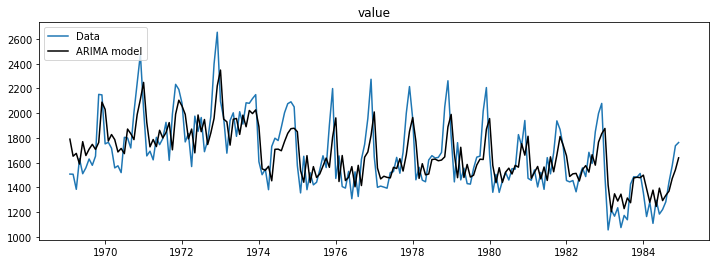

In [5]:
model.plot_fit(figsize=(12,4))

pyflux package also provides visualization on forecast. Here we set up h = 5, i.e. forecast 5 time steps:

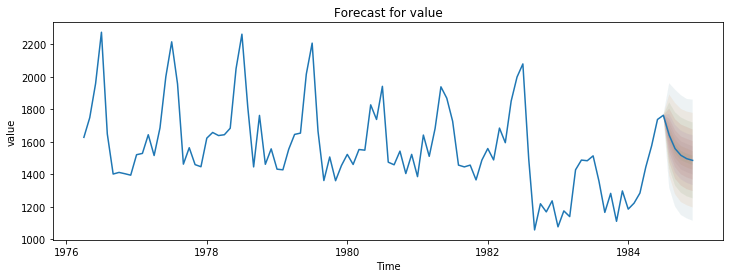

In [6]:
model.plot_predict(h=5, oos_data=data.iloc[-20:], past_values=100, figsize=(12,4))

Note that when doing forecast, the time index is not correct.

For example, the forecast time should be time > 1984.9166667. However, the time indices in the preidctions just used the last 5 time steps from data. But the **value** are certainly forecast values!

In [7]:
data.tail(2)

,Unnamed: 0,time,value,seat_belt,oil_crisis
time,,,,,
1984.833333,191,1984.833333,1737,1.0,1.0
1984.916667,192,1984.916667,1763,1.0,1.0


In [86]:
model.predict(h=5, oos_data=data.iloc[-5:])

,value
time,
1984.583333,1640.148331
1984.666667,1557.500462
1984.750000,1516.146210
1984.833333,1495.453914
1984.916667,1485.100175


## Update Model and Forecast For Each Time Step

To seriously test the model accuracy and compute the errors, we need to implement the similar step; only forecast one time step and update training dataset by adding data from test dataset.

In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
size = int(len(data)*0.67)
train, test = data.iloc[:size, :], data.iloc[size:, :]
train.tail(2)

,Unnamed: 0,time,value,seat_belt,oil_crisis
time,,,,,
1979.500000,127,1979.500000,1427,0.0,1.0
1979.583333,128,1979.583333,1554,0.0,1.0


Next we wrap the ARIMAX model as a function. But keep in mind that we have identify optimal ARIMA model use $p=12$, $d=q=1$. Therefore, we try to consider ARIMAX(12,1,1). In the ARIMAX model we can use `integ=1` for $d=1$. To be more clear, we difference the data manually, and still implement ARIMAX(12,0,1). 

In [22]:
def ARIMAX_forecast(data, p=1, d=0, q=1):
    if d == 0: # no difference
        size = int(len(data)*0.67)
        train, test = data.iloc[:size, :], data.iloc[size:, :]
        predictions = list()
        for t in range(len(test)):
            model = pf.ARIMAX(data=train, formula='value~1+seat_belt+oil_crisis', ar=p, ma=q, family=pf.Normal())
            model.fit("MLE")
            val = test.iloc[t:t+1, :]    
            yhat = model.predict(h=1, oos_data=train.iloc[-12:, :])
            predictions.append(list(yhat['value'])[0])    
            train = pd.concat([train, val])

    elif d == 1: # one differenced
        diff_data = data.iloc[1:]
        diff_data['diff'] = np.array(data['value'].tolist()[1:]) - np.array(data['value'].tolist()[:-1])
        size = int(len(diff_data)*0.67)
        train, test = diff_data.iloc[:size, :], diff_data.iloc[size:, :]
        predictions = list()
        for t in range(len(test)):
            model = pf.ARIMAX(data=train, formula='diff~1+seat_belt+oil_crisis', ar=p, ma=q, family=pf.Normal())
            model.fit("MLE")
            val = test.iloc[t:t+1, :]    
            yhat = model.predict(h=1, oos_data=train.iloc[-12:, :])
            predictions.append(list(yhat['diff'])[0]+train['value'].tolist()[-1])
            train = pd.concat([train, val])

    error = mean_squared_error(test['value'].tolist(), predictions)/len(test)

    #print (error)

    plt.figure(figsize=(12,4))
    plt.plot(test.index, test['value'], label='data')
    plt.plot(test.index, predictions, label='prediction')
    plt.ylabel('value')
    plt.title('Predicted Deaths' + ' by ARIMAX' + str((p, d, q))+', MSE:'+str(round(error, 3)))
    plt.legend(loc='best')
    plt.show()

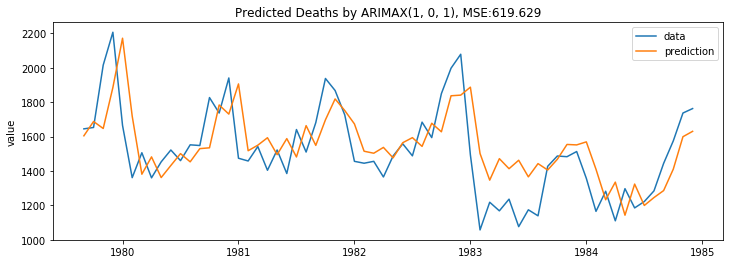

In [25]:
ARIMAX_forecast(data, p=1, q=1)

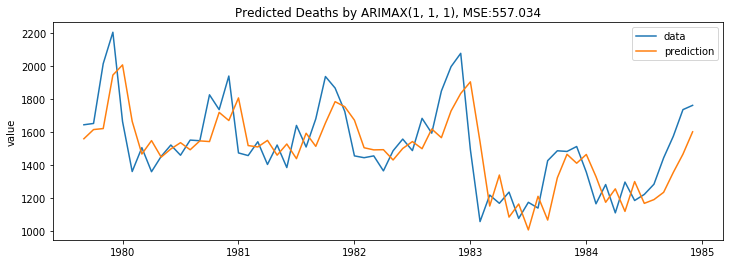

In [24]:
ARIMAX_forecast(data, p=1, d=1, q=1)

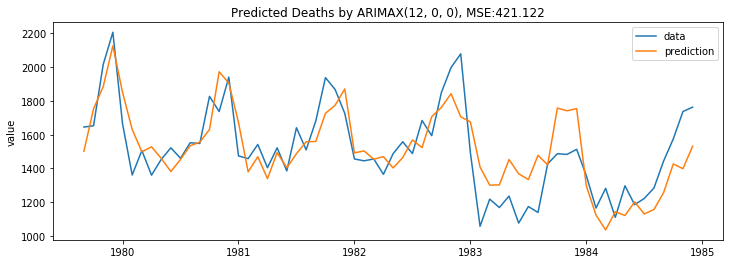

In [26]:
ARIMAX_forecast(data, p=12, q=0)

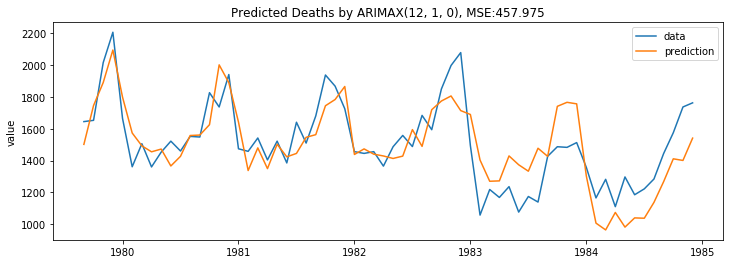

In [27]:
ARIMAX_forecast(data, p=12, d=1, q=0)

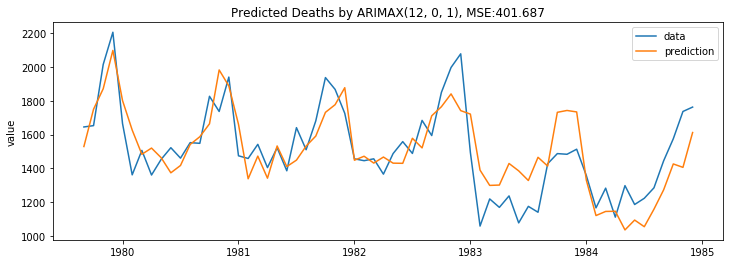

In [28]:
ARIMAX_forecast(data, p=12, q=1)

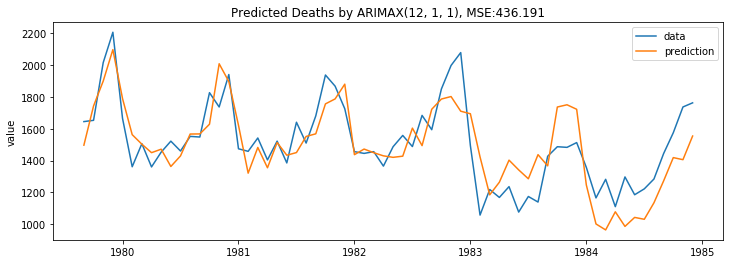

In [29]:
ARIMAX_forecast(data, p=12, d=1, q=1)

We can see using ARIMAX(12,1,1) is not necessary to be better tahn ARIMA(12,1,1), even worse than ARIMAX(12,0,1).

# [STL Decomposition](https://otexts.org/fpp2/stl.html) in Python

Next we can use Python to study the seasonal pattern. By the [Stackoverflow blog](https://stackoverflow.com/questions/20672236/time-series-decomposition-function-in-python) and [Jason's blog](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/), we can implement the [Seasonal Decomposition package](http://www.statsmodels.org/stable/release/version0.6.html?highlight=seasonal#seasonal-decomposition) to perform:

$$x(t) = s(t) + m(t) + \epsilon(t)$$

here $t$ is the time coordinate and $x$ is the data. $s$ is the seasonal component, $\epsilon$ is the random error term and $m$ is the trend. The components are additive. The decomposition can also be multiplicative:

$$x(t) = s(t).m(t).\epsilon(t)$$

When should we consider Multiplicative decomposition? The [David Ziganto's blog](https://dziganto.github.io/python/time%20series/Introduction-to-Time-Series/) has talked about it: 

If the seasonality and residual components are independent of the trend, then you have an additive series. If the seasonality and residual components are in fact dependent, meaning they fluctuate on trend, then you have a multiplicative series.

On the other hand, [Gaussian Local Level models](https://pyflux.readthedocs.io/en/latest/llm.html) in pyflux could be useful too. But I cannot figure out how it works.

In [117]:
import statsmodels.api as sm

In [151]:
new_data = data['value']
new_data.index = pd.to_datetime([str(int(x))+'-'+str(round(12*(x-int(x))+1)) for x in data['time'].tolist()])
new_data.head()

1969-01-01    1687
1969-02-01    1508
1969-03-01    1507
1969-04-01    1385
1969-05-01    1632
Name: value, dtype: int64

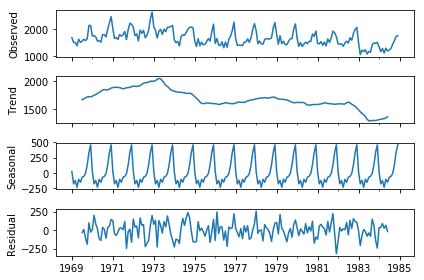

In [149]:
res = sm.tsa.seasonal_decompose(new_data, model='additive')
resplot = res.plot()

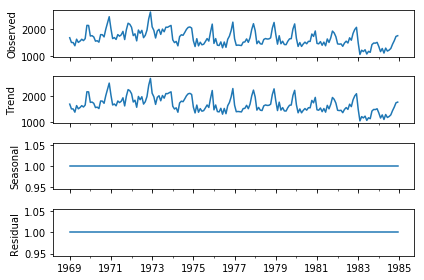

In [150]:
res = sm.tsa.seasonal_decompose(new_data, model='multiplicative', freq=1)
resplot = res.plot()